<a href="https://colab.research.google.com/github/xs912/En-Ru-Translator-Seq2Seq-/blob/main/Ru_En_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.4.0

In [ ]:
from google.colab import files 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
%matplotlib inline
from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from google.colab import drive
import time 
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Concatenate, Bidirectional, SpatialDropout1D, Dropout, BatchNormalization 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Adadelta, Adamax 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import clear_output
import logging
logging.disable(logging.WARNING)
import pickle
import seaborn as sns
import string
import tensorflow as tf
import re

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Data download*

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/Eng-Rus.txt', encoding='utf-8', sep='	',  names=['English', 'Russian'], skiprows=1)
df.sample(5)

,English,Russian
118852,When am I supposed to do that?,Когда я должен это сделать?
19497,Look at what we made.,"Смотрите, что мы сделали."
72123,How often do you go abroad?,Как часто вы ездите за границу?
67339,It's computer-generated.,Оно создано на компьютере.
114390,I'm hungry. What about you?,Я голоден. А ты?


In [ ]:
columns_titles = ["Russian","English"]
df=df.reindex(columns=columns_titles)
df.sample(5)

,Russian,English
58208,Я знаю семью Джексонов.,I know the Jacksons.
72700,"Если Вы счастливы, то и я счастлива.","If you're happy, I'm happy."
47469,Выезжай завтра.,Leave tomorrow.
1146,Я невредим.,I'm unhurt.
49348,Замолчи и ешь.,Shut up and eat.


In [ ]:
df.shape

(125287, 2)

In [ ]:
df.isna().sum() # check for empty entries

Russian    0
English    0
dtype: int64

*Data preparation*

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)          # shuffle the contents
df.reset_index (inplace = True, drop = True)
df.iloc[1,:]

Russian      Ответа никто не знает.
English    Nobody knows the answer.
Name: 1, dtype: object

In [ ]:
# df = df[10000:50000]  # reduce the dataset size for experiments

*Text cleanup*

In [ ]:
# function for text preprocessing

def preprocess_sentence(w): 

  w = w.lower().strip()
  w = re.sub(r"([?.!,])", r" \1 ", w) # add a space between punctuation marks
  w = re.sub(r'[" "]+', " ", w) # remove extra spaces

  # replace with spaces all except (a-z, A-Z, а-я, А-Я")
  w = re.sub(r"[^a-zA-Zа-яА-Я']+", " ", w)

  w = w.strip()

  return w

In [ ]:
# remove apostrophes
with open("/content/drive/My Drive/Базы/exp_contracted.txt", 'rb') as f:
    contractions= pickle.load(f)

def expand_contras(text):
    '''
    the function accepts a word or a list of words.
     If an abbreviated entry is detected, a conversion is performed:
    it's --> it is
    won't --> would not
    '''
    if type(text) is str:
        for key in contractions:
            value = contractions[key]
            text = text.replace(key, value)
        return text
    else:
        return text

df.English = df.English.apply(lambda x: expand_contras(x))
df.sample(10)

,Russian,English
81181,Где ты была?,Where've you been?
83115,"Извини, мне надо идти.","Sorry, I have got to go."
97845,Я никому не хочу причинять вред.,I do not want to hurt anyone.
84909,Что здесь сегодня произошло?,What happened here today?
67046,Я не могу отложить свой отъезд.,I cannot postpone my departure.
91315,Ты такой молодой.,You're so young.
80445,Кто-нибудь тебя видел?,Anybody see you?
116695,Что ты слышала?,What have you heard?
94148,"Не делай вид, что не знаешь, о чем я.",Don't pretend you do not know what I mean.
40975,Еды у нас более чем достаточно.,We've got more than enough food.


In [ ]:
# remove punctuation marks
df.Russian = df.Russian.apply(lambda x: preprocess_sentence(x))
df.English = df.English.apply(lambda x: preprocess_sentence(x))

# add columns to count the number of words in sentences
df['source_word_count']= df.Russian.apply(lambda x: len(x.split()))
df['trans_word_count']= df.English.apply(lambda x: len(x.split()))

df.sample(5)

,Russian,English,source_word_count,trans_word_count
33637,могу я воспользоваться туалетом,can i use the bathroom,4,5
119414,вы не бог,you're not god,3,3
89857,нам надо отложить наш отъезд,we have to postpone our departure,5,6
92194,это истина,that's the truth,2,3
27867,как насчет чашки чая,how about a cup of tea,4,6


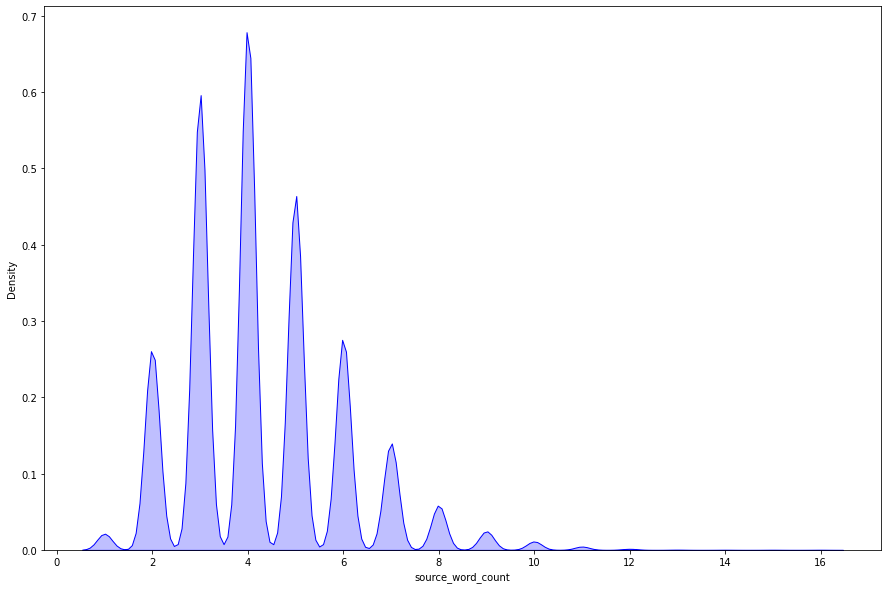

In [ ]:
plt.figure(figsize=(15,10))
sns.kdeplot(x=df.source_word_count, shade=True, color='blue', label='Real')

In [ ]:
max(df.source_word_count)

16

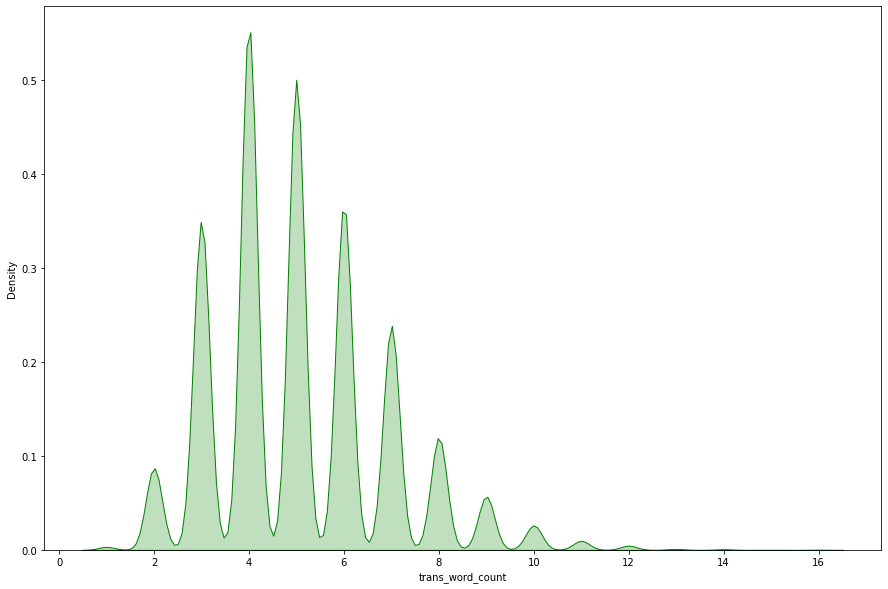

In [ ]:
plt.figure(figsize=(15,10))
sns.kdeplot(x=df.trans_word_count, shade=True, color='green', label='Real')

In [ ]:
max(df.trans_word_count)

16

In [ ]:
# add start and end tags to the translation
df['English'] = df.English.apply(lambda x: 'start '+ x + ' end')
# df['Russian'] = df.Russian.apply(lambda x: 'start '+ x + ' end')
df.sample(5)

,Russian,English,source_word_count,trans_word_count
31458,нам лучше сделать то о чем они просят,start we'd better do what they ask end,8,6
22711,прошу просто поверь мне ладно,start i just need you to trust me ok end,5,8
82942,что с тобой случилось,start what happened to you end,4,4
44042,мой брат стал поваром,start my brother became a cook end,4,5
96825,вы уверены что вам хватит денег,start are you sure that you have enough money end,6,8


In [ ]:
# convert into lists for tokenizer
# source_texts = df.English.to_list()
# trans_texts = df.Russian.to_list()
source_texts = df.Russian.to_list()
trans_texts = df.English.to_list()

def tokenize_sentence(text):

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)

source_tokenizer, source_encoded = tokenize_sentence(text= source_texts)
trans_tokenizer, trans_encoded = tokenize_sentence(text= trans_texts)

In [ ]:
source_encoded[100:105]

[[1535, 146, 144],
 [5, 287, 4461],
 [1, 17, 4, 22, 142],
 [3, 3501],
 [5, 51, 1280, 591]]

In [ ]:
source_index_word = source_tokenizer.index_word
source_word_index= source_tokenizer.word_index

SOURCE_VOCAB_SIZE = len(source_tokenizer.word_counts)+1
SOURCE_VOCAB_SIZE # Russian dictionary size

11126

In [ ]:
trans_encoded[30000:30005]

[[1, 58, 14, 8, 80, 315, 2],
 [1, 54, 22, 67, 2],
 [1, 3, 1408, 2],
 [1, 4, 39, 24, 321, 2],
 [1, 6, 4, 13, 31, 2]]

In [ ]:
trans_index_word = trans_tokenizer.index_word
trans_word_index= trans_tokenizer.word_index

TRANS_VOCAB_SIZE=len(trans_tokenizer.word_counts)+1
TRANS_VOCAB_SIZE # English dictionary size

3158

In [ ]:
max_source_len = 0
for i in range(len(source_encoded)):
  if len(source_encoded[i]) > max_source_len:
    max_source_len= len(source_encoded[i])

max_trans_len = 0
for i in range(len(trans_encoded)):
  if len(source_encoded[i]) > max_trans_len:
    max_trans_len= len(trans_encoded[i])

source_padded = pad_sequences(source_encoded, maxlen=max_source_len, padding='post')
trans_padded = pad_sequences(trans_encoded, maxlen=max_trans_len, padding='post')
source_padded

array([[  22,   40, 3494, ...,    0,    0,    0],
       [ 439,   62,    2, ...,    0,    0,    0],
       [ 463, 1038, 4449, ...,    0,    0,    0],
       ...,
       [   1,  178,  119, ...,    0,    0,    0],
       [  20,    3,   59, ...,    0,    0,    0],
       [  41, 1248,   60, ...,    0,    0,    0]], dtype=int32)

In [ ]:
trans_padded.shape

(125287, 18)

In [ ]:
source_padded= np.array(source_padded)
trans_padded= np.array(trans_padded)

X_train, X_test, y_train, y_test = train_test_split(source_padded, trans_padded, test_size=0.1, random_state=0) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112758, 16), (12529, 16), (112758, 18), (12529, 18))

In [ ]:
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    """
    The class implements the attention mechanism proposed by D. Bogdanov (https://arxiv.org/pdf/1409.0473.pdf).
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weighting variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Function for calculating the importance of one decoder state step by step """

            assert_msg = "The states must be a list. However, the states {} are of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            enc_seq_len, enc_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Calculate weights S.Wa, where S=[s0, s1, ..., si]"""
            # <= batch_size*enc_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, enc_hidden))
            # <= batch_size*enc_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, enc_seq_len, enc_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Calculate hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ Apply tanh(S.Wa + hj.Ua) """
            # <= batch_size*enc_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, enc_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ Apply softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, enc_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, enc_seq_len))
            # <= batch_size, enc_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            fake_state = K.zeros_like(inputs) 
            fake_state = K.sum(fake_state, axis=[1, 2])  
            fake_state = K.expand_dims(fake_state)  
            fake_state = K.tile(fake_state, [1, hidden_size])  
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  

        """ Importance outputs """
        # e_outputs => (batch_size, de_seq_len, enc_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Layer outputs """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# Encoder 

encoder_inputs = Input(shape=(max_source_len,)) 
enc_emb = Embedding(SOURCE_VOCAB_SIZE, 1024)(encoder_inputs)
enc_emb = SpatialDropout1D(0.2)(enc_emb)
enc_emb = BatchNormalization()(enc_emb)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

encoder_states =[final_enc_h, final_enc_c]

# Decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(TRANS_VOCAB_SIZE, 1024) 
dec_emb = dec_emb_layer(decoder_inputs)

# The LSTM layer that takes the encoder state as the initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Combine the attention layer output and the LSTM decoder layer output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer
decoder_dense = Dense(TRANS_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


In [ ]:
######################
# Neural network training model
######################
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

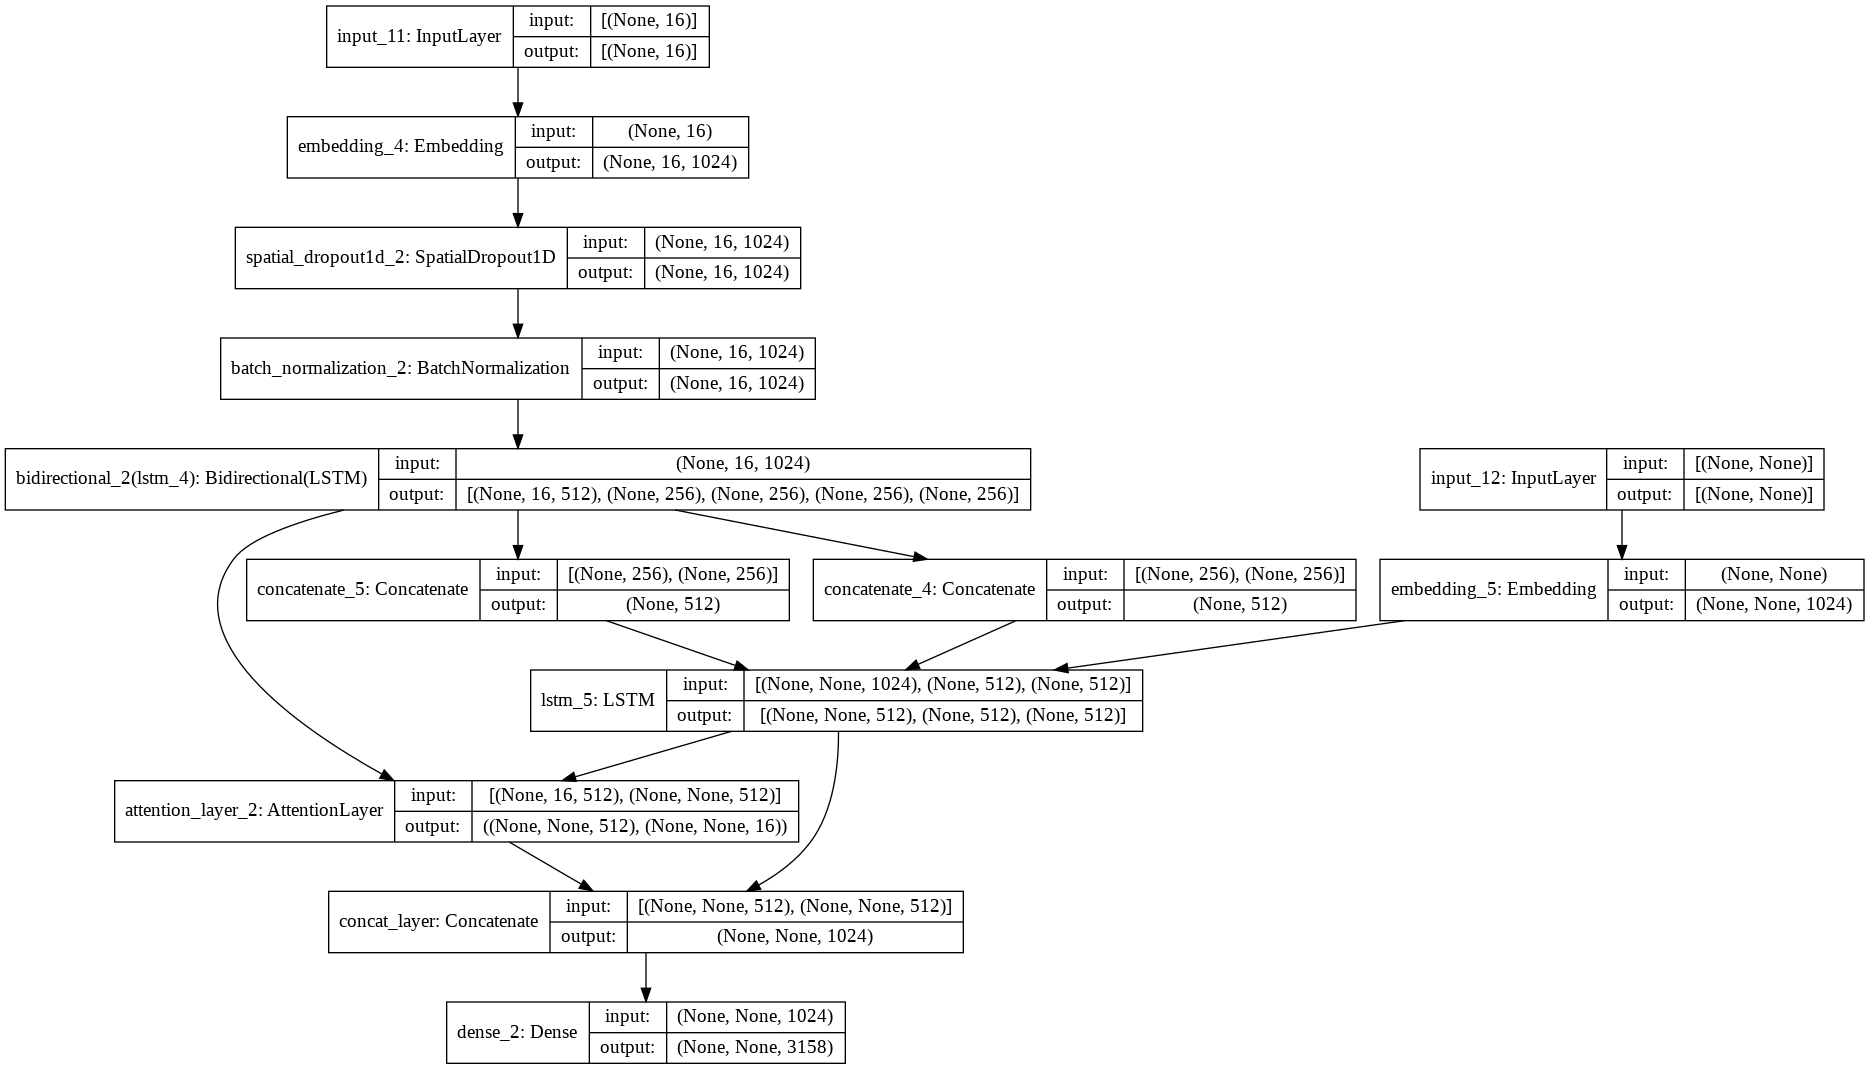

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Model compilation
opt = Adam(0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/My Drive/Базы/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Training
encoder_input_data = X_train
decoder_input_data = y_train[:,:-1]
decoder_target_data =  y_train[:,1:]

# Check
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

In [ ]:
EPOCHS= 10
opt = 'adam'

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=64,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test), shuffle=True,
                    callbacks= callbacks_list)

Epoch 1/10
1762/1762 [==============================] - 469s 262ms/step - loss: 1.0015 - accuracy: 0.8311 - val_loss: 0.1532 - val_accuracy: 0.9631
Epoch 2/10
1762/1762 [==============================] - 459s 261ms/step - loss: 0.1027 - accuracy: 0.9737 - val_loss: 0.0694 - val_accuracy: 0.9811
Epoch 3/10
1762/1762 [==============================] - 457s 259ms/step - loss: 0.0485 - accuracy: 0.9863 - val_loss: 0.0496 - val_accuracy: 0.9863
Epoch 4/10
1762/1762 [==============================] - 455s 258ms/step - loss: 0.0365 - accuracy: 0.9895 - val_loss: 0.0422 - val_accuracy: 0.9881
Epoch 5/10
1762/1762 [==============================] - 455s 258ms/step - loss: 0.0322 - accuracy: 0.9906 - val_loss: 0.0393 - val_accuracy: 0.9888
Epoch 6/10
1762/1762 [==============================] - 468s 265ms/step - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.0358 - val_accuracy: 0.9900
Epoch 7/10
1762/1762 [==============================] - 466s 264ms/step - loss: 0.0267 - accuracy: 0.9921 - val_

In [ ]:
model.save_weights("/content/drive/My Drive/Базы/model_rus-eng.h5")
model.save("/content/drive/My Drive/Базы/model_rus-eng.h5")

10 эпох обучения. Optimizer =  adam


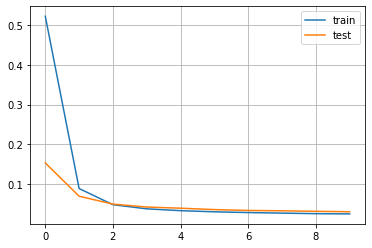

In [ ]:
  print('{} эпох обучения. Optimizer = '.format(EPOCHS), opt)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test') 
  plt.legend()
  plt.grid()
  plt.show()

*Preparing and running a working neural network*

In [ ]:
######################
# Working model to output the translation of the source text
######################
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(max_source_len,512))

dec_states = [decoder_state_h, decoder_state_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)


attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])

decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [ ]:
######################
# Running the working model
######################
def get_predicted_sentence(input_seq):
    # Encode the input data as vectors of states.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
  
    # Generate an empty sequence of results of length 1.
    target_seq = np.zeros((1,1))
    
    # Fill in the first character of the result sequence with the starting character.
    target_seq[0, 0] = trans_word_index['start']
    
    # Sampling cycle for a series of sequences
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            # convert the maximal index into a word in the target language
            sampled_char = trans_index_word[sampled_token_index]

        if (sampled_char!='end'):
            # add to the decoded sentence
            decoded_sentence += ' '+ sampled_char
        
        # Exit condition: reaching maximum length or end tag.
        if (sampled_char == 'end' or len(decoded_sentence.split()) >= max_source_len):
            stop_condition = True
        
        # Update the sequence with the result (length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Updating states
        enc_h, enc_c = h, c
    
    return decoded_sentence

In [ ]:
# Convert x and y back into words
def get_trans_sentence(input_sequence):
    sentence = ''
    for i in input_sequence:
      if i != 0:
        sentence = sentence + trans_index_word[i] + ' '
    return sentence 

def get_source_sentence(input_sequence):
    sentence = ''
    for i in input_sequence:
      if i != 0:
        sentence =sentence + source_index_word[i] + ' '
    return sentence


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu

def BLEU(sent1,sent2):
  sent1_bleu = []
  sent2_bleu = []

  for w1 in sent2:
    sent2_bleu.append(w1.split())

  for i, w2 in enumerate(sent1):
    sent1_bleu.append([w2.split()])

  sf = SmoothingFunction()

  score = corpus_bleu(sent1_bleu,sent2_bleu,weights = (0,1,0,0),smoothing_function= sf.method4)
  return score

In [ ]:
smoothie = SmoothingFunction().method4
for i in np.random.randint(1, 100, size=4):
  print("Предложение на русском языке:   ",get_source_sentence(X_test[i]))
  print("Предложение на английском языке:",get_trans_sentence(y_test[i])[5:-4])
  print("Результат перевода нейросетью:  ",get_predicted_sentence(X_test[i].reshape(1, max_source_len))[:])  
  print('Оценка BLEU: {}'.format(sentence_bleu([get_trans_sentence(y_test[i])[6:-5]], get_predicted_sentence(X_test[i].reshape(1, max_source_len))[1:])))
  print("----------------------------------------------------------------------------------------")


Предложение на русском языке:    я думал ты хочешь быть танцовщицей 
Предложение на английском языке:  i thought you wanted to be a dancer 
Результат перевода нейросетью:    i thought you wanted to be a dancer
Оценка BLEU: 1.0
----------------------------------------------------------------------------------------
Предложение на русском языке:    мы не сможем пойти 
Предложение на английском языке:  we cannot go 
Результат перевода нейросетью:    we cannot go
Оценка BLEU: 1.0
----------------------------------------------------------------------------------------
Предложение на русском языке:    он вернулся из канады 
Предложение на английском языке:  he returned from canada 
Результат перевода нейросетью:    he returned from canada
Оценка BLEU: 1.0
----------------------------------------------------------------------------------------
Предложение на русском языке:    я нечасто куда то хожу 
Предложение на английском языке:  i do not go out much 
Результат перевода нейросетью:    i do

Модель была проверена для слоев RNN, GRU и LSTM. Наименее хорошие результаты показала модель с RNN. Это можно объяснить тем, что данный слой не способен обрабатывать долгосрочные зависимости. GRU (при надлежащем подборе гиперпараметров) обеспечивает достаточно неплохие результаты, сопоставимые с LSTM. Учится он быстрее, чем LSTM, поэтому его можно использовать в задачах, где время обучения критично. Наиболее эффективным оказалась модель с использованием Bidirectional LSTM. Для моделей были проведены эксперименты с частичной выборкой (40000 пар, в целях экономии времени), изменением гиперпараметров. Лучшие гиперпараметры были применены для полной выборки. В результате полученная модель на основе Bidirectional LSTM (learning rate = 0.01, batch = 64, 10 эпох, оптимизатор Adam) обеспечивает точность на проверочной выборке, равную 0,9915. Средняя оценка BLEU для результата работы модели составляет 1. 
Результаты экспериментов представлены в таблице ниже.


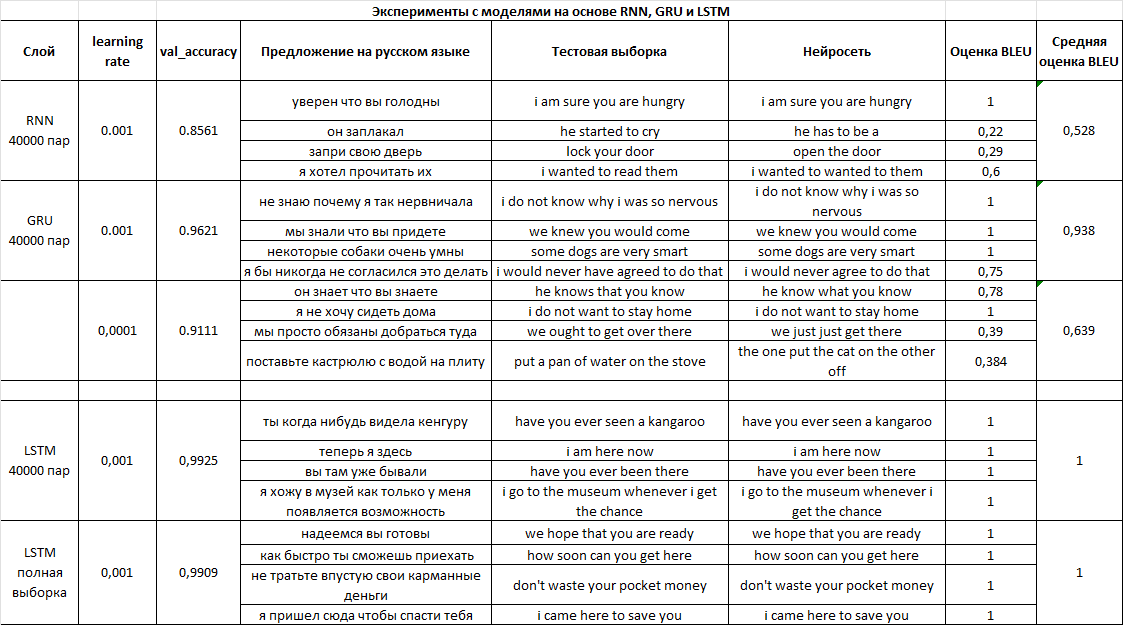



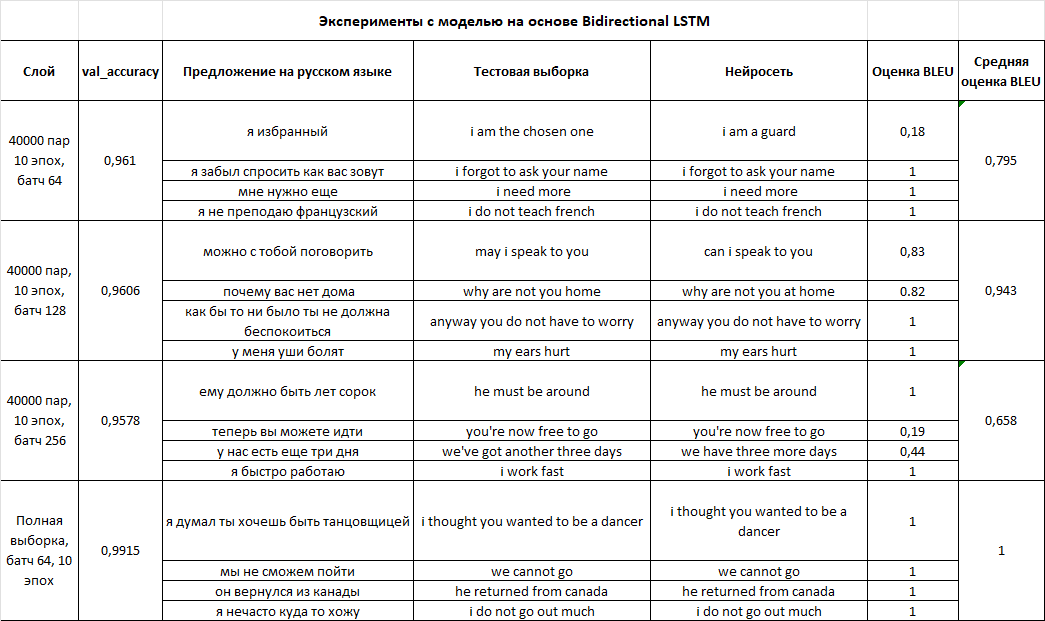
